# Image Classification

- Utilize state-of-the-art pre-trained models from torchvision for fast fine-tuning and inference
- Feature learning rate finder to identify most suitable learning rate initialization
- Error analysis by confusion matrix
- Visualization model's vision

For Colab,

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%capture
!unzip /content/drive/MyDrive/Dataset.zip -d /content/dataset

In [145]:
import torch
import random

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

----
## Preparing Dataset for Training/Testing

Split data into test and train dataset

In [21]:
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [59]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_dir = "split_dataset/train"
test_dir = "split_dataset/test"
valid_dir = "split_dataset/valid"


train_transforms = transforms.Compose([
                           transforms.RandomCrop(100, pad_if_needed=True, fill=255),
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.CenterCrop(100),
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])


train_data = datasets.ImageFolder(root = train_dir, transform = train_transforms)
test_data = datasets.ImageFolder(root = test_dir, transform = test_transforms)
valid_data = datasets.ImageFolder(root = valid_dir, transform = test_transforms)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 14034
Number of validation examples: 1498
Number of testing examples: 1502


In [60]:
BATCH_SIZE = 4

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

## Taking a look at our Dataset

In [40]:
import matplotlib.pyplot as plt

In [41]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image 

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

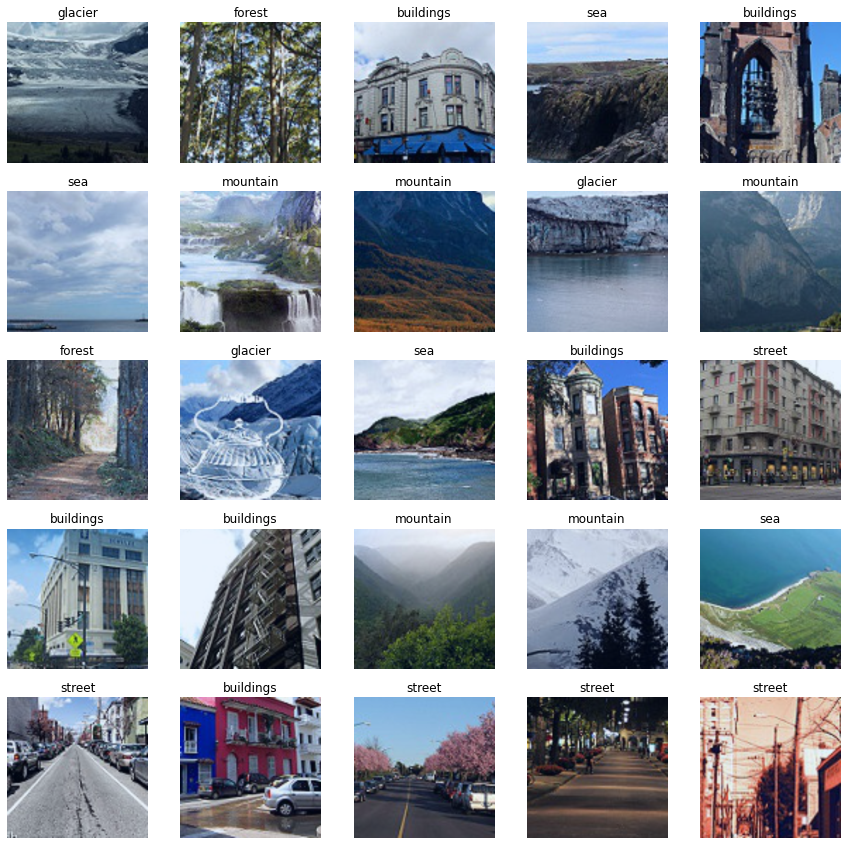

In [61]:
import random
import numpy as np

N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in [train_data[i] \
                                      for i in random.sample(list(np.arange(len(train_data))),N_IMAGES)]])

classes = train_data.classes

plot_images(images, labels, classes)

## Prepare Pre-trained Model (from torchvision.models)

- Change the output dims according to desired number of classes

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

**Load Pre-Trained Model**

In [43]:
model = models.resnet50(pretrained = True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [44]:
IN_FEATURES = model.fc.in_features
OUTPUT_DIM = len(test_data.classes)
model.fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,520,326 trainable parameters


**Or load custom trained weight**

In [ ]:
weight_path = '/content/drive/MyDrive/PyTorch_Weights/resnet50-fontFamily-DISCRETE-BG-model.pt'

model = models.resnet50(pretrained = False)
model.fc = nn.Linear(2048, len(train_data.classes))
weight = torch.load(weight_path, map_location='cuda')
model.load_state_dict(weight)
model = model.to('cuda')

## Find the optimum learning rate

In [45]:
from lr_finder import LRFinder

In [46]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [47]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:08<00:00, 10.47it/s]


Stopping early, the loss has diverged


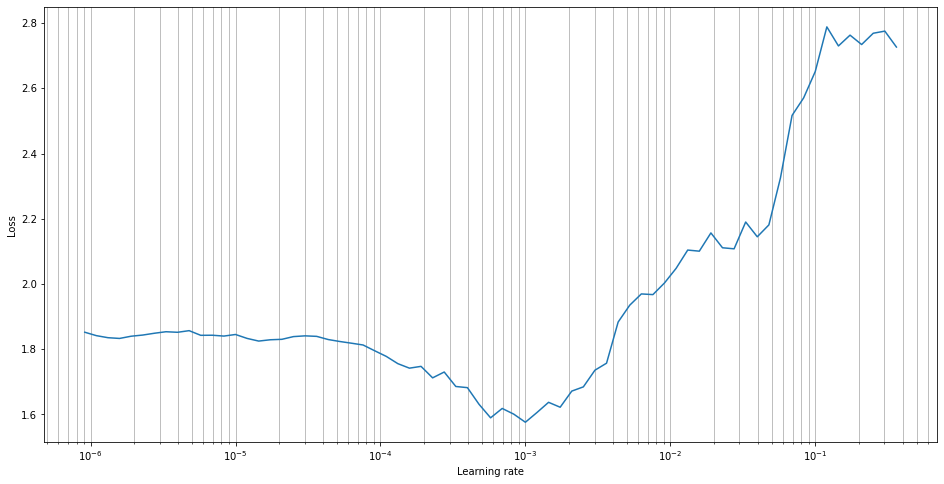

In [48]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 10)

## Preparation before Training

In [62]:
FOUND_LR = 5e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters(), 'lr': FOUND_LR}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [66]:
EPOCHS = 3
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

## Model Training

In [67]:
from train_and_eval import train, evaluate, epoch_time

import time

In [68]:
best_valid_loss = float('inf')
topk_accuracy = 1

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device, topk_accuracy)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device, topk_accuracy)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
#         torch.save(model.state_dict(), '/checkpoints/model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @{topk_accuracy}: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @{topk_accuracy}: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 4m 39s
	Train Loss: 0.725 | Train Acc @1:  72.81% | Train Acc @1:  72.81%
	Valid Loss: 0.692 | Valid Acc @1:  75.13% | Valid Acc @1:  75.13%
Epoch: 02 | Epoch Time: 4m 59s
	Train Loss: 0.656 | Train Acc @1:  75.61% | Train Acc @1:  75.61%
	Valid Loss: 0.542 | Valid Acc @1:  83.13% | Valid Acc @1:  83.13%
Epoch: 03 | Epoch Time: 5m 4s
	Train Loss: 0.442 | Train Acc @1:  84.20% | Train Acc @1:  84.20%
	Valid Loss: 0.367 | Valid Acc @1:  88.40% | Valid Acc @1:  88.40%


## Model Evaluation

In [70]:
# test_model = models.resnet50(pretrained = False)
# test_model.fc = nn.Linear(2048, test_data.classes)

# weight = torch.load('/checkpoints/model.pt', map_location='cuda')
# test_model.load_state_dict(weight)

# test_model = test_model.to('cuda')
# test_model.eval()

evaluate(model, test_iterator, criterion, device, topk=1)

(0.3425118389859563, 0.8789893617021277, 0.8789893617021277)

# Error Analysis

In [92]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [93]:
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)

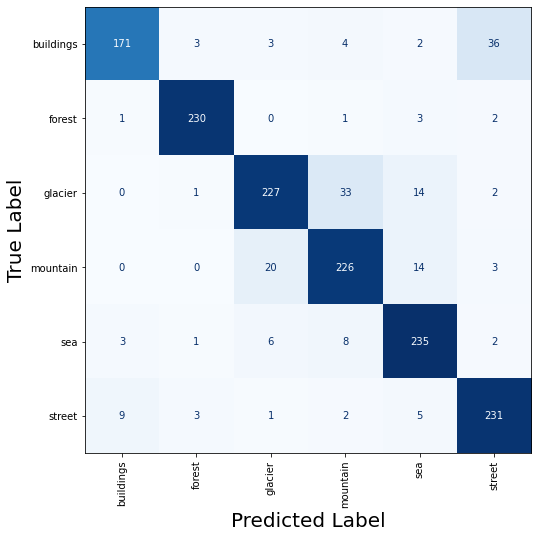

In [78]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, classes):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 20)
    plt.ylabel('True Label', fontsize = 20)
  

plot_confusion_matrix(labels, pred_labels, classes)


## Appendix

In [79]:
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [118]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [119]:
outputs, labels = get_representations(model, train_iterator)

In [123]:
from sklearn import decomposition

def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [121]:
def plot_representations(data, labels, classes, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'hsv')
    #handles, _ = scatter.legend_elements(num = None)
    #legend = plt.legend(handles = handles, labels = classes)

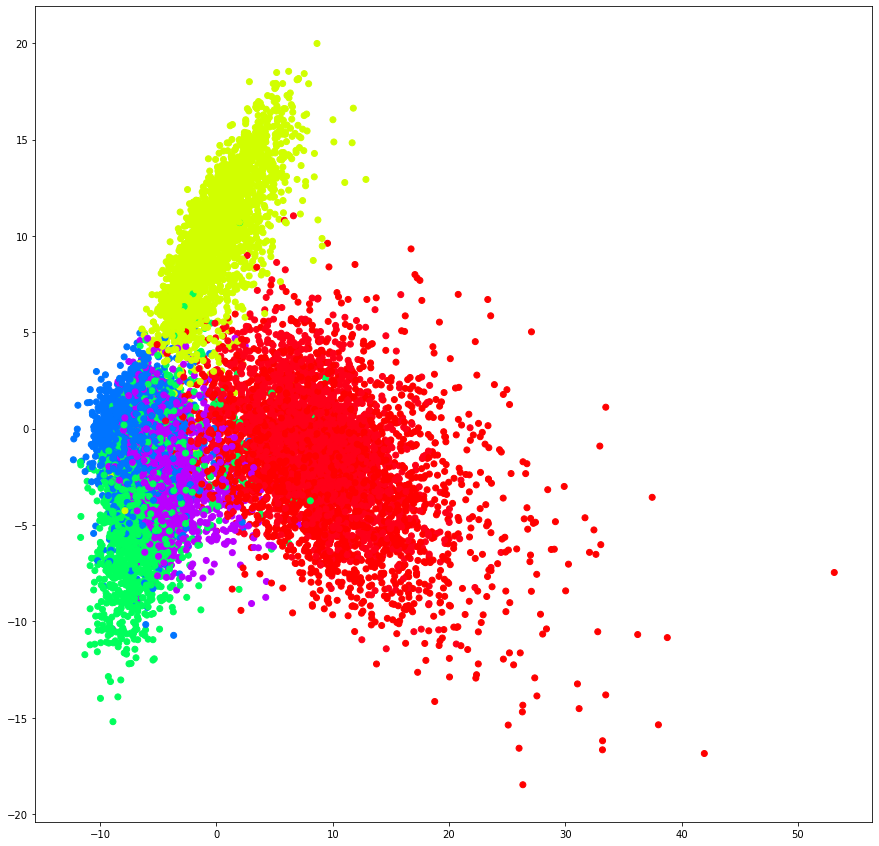

In [124]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

In [128]:
from sklearn import manifold

def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

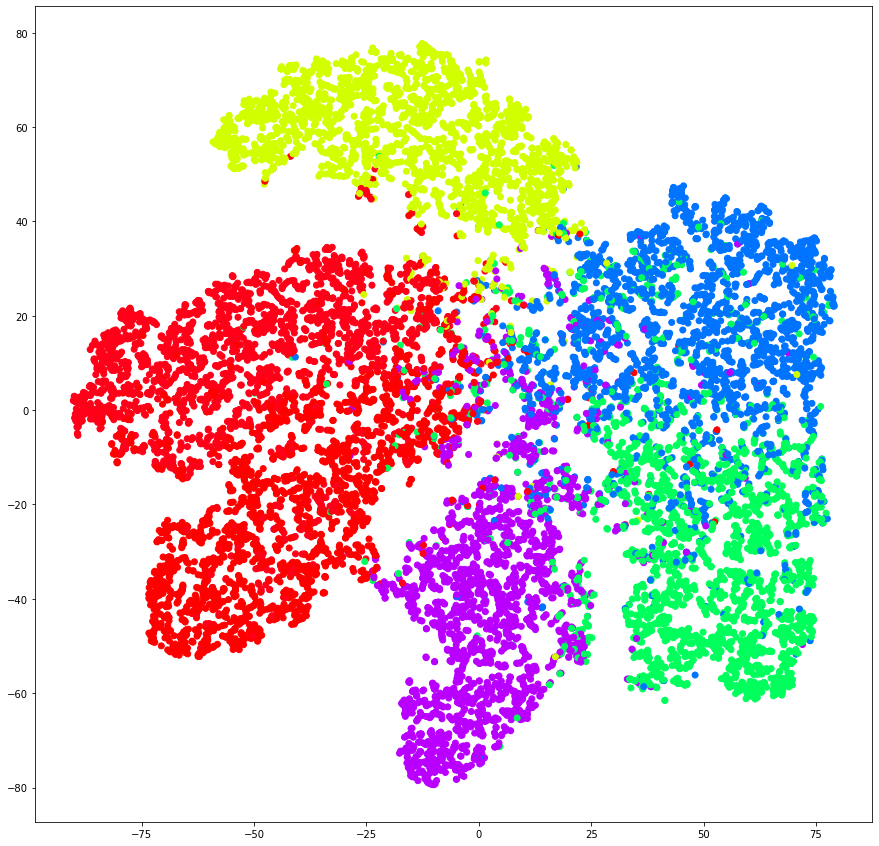

In [129]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, classes)

In [130]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

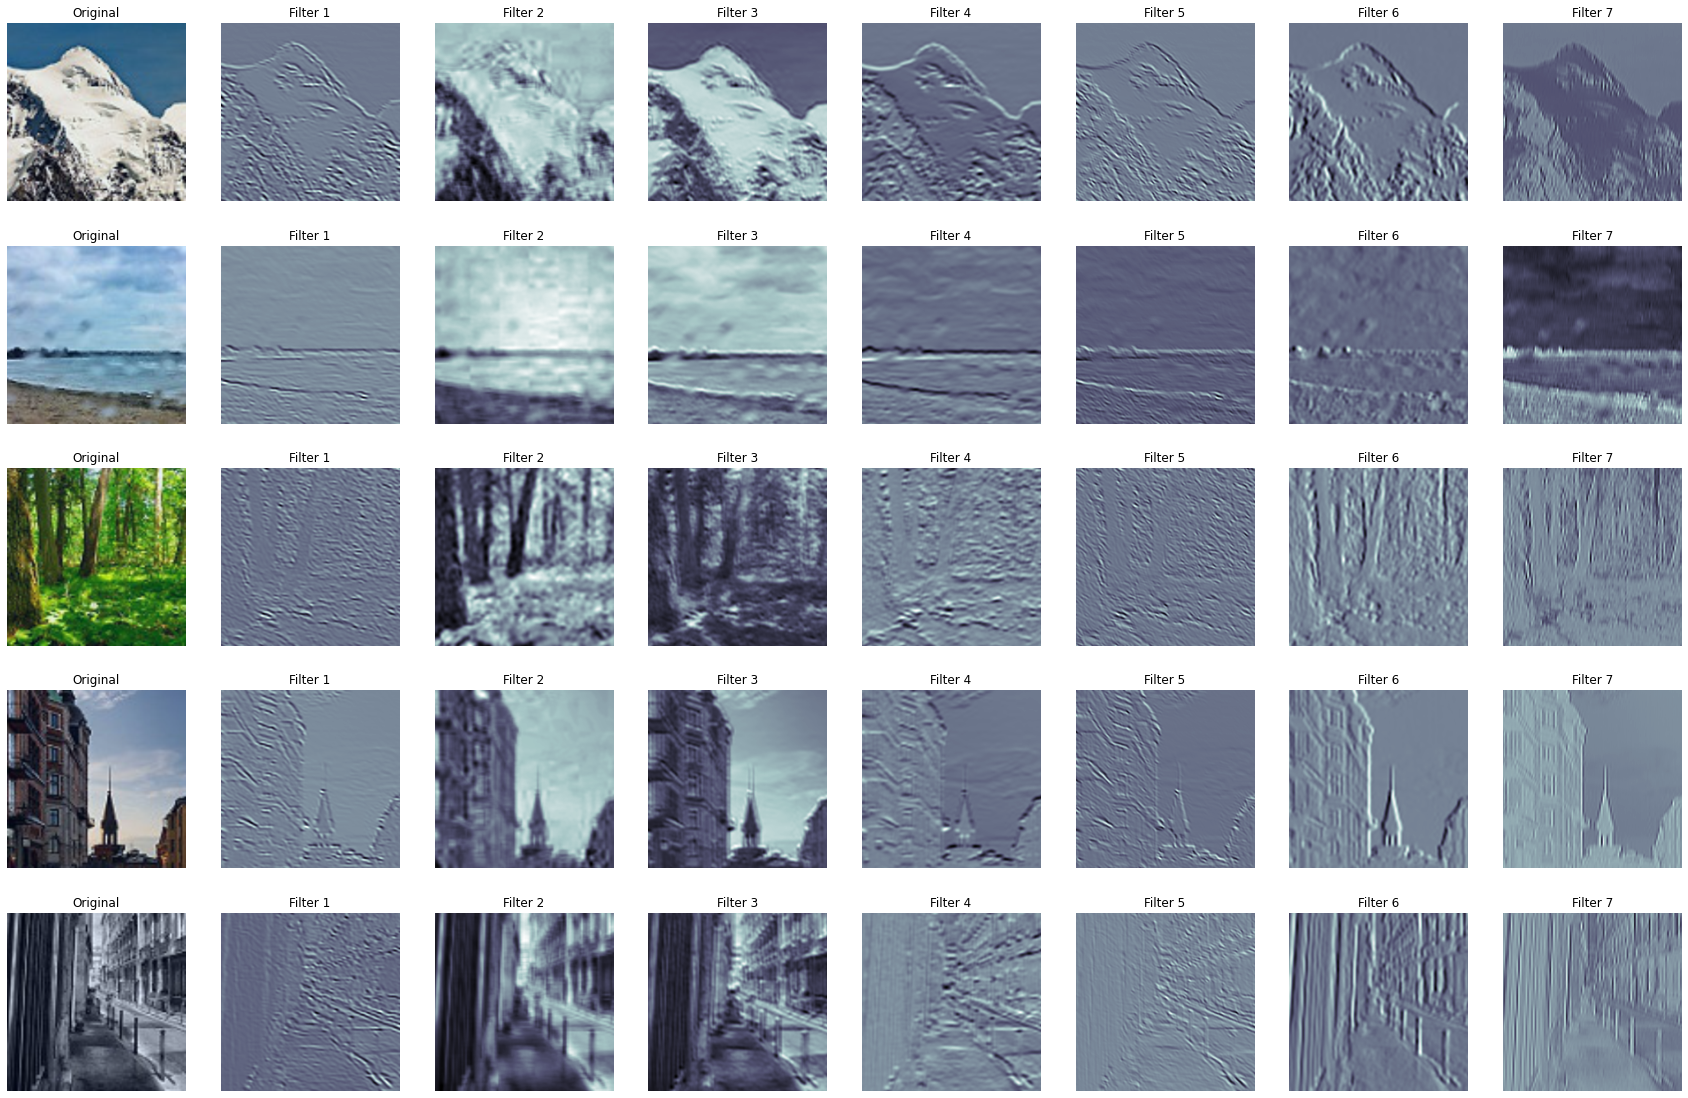

In [139]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [train_data[i] for i in random.sample(list(np.arange(len(train_data))),N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

In [140]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
        
    fig.subplots_adjust(wspace = -0.9)

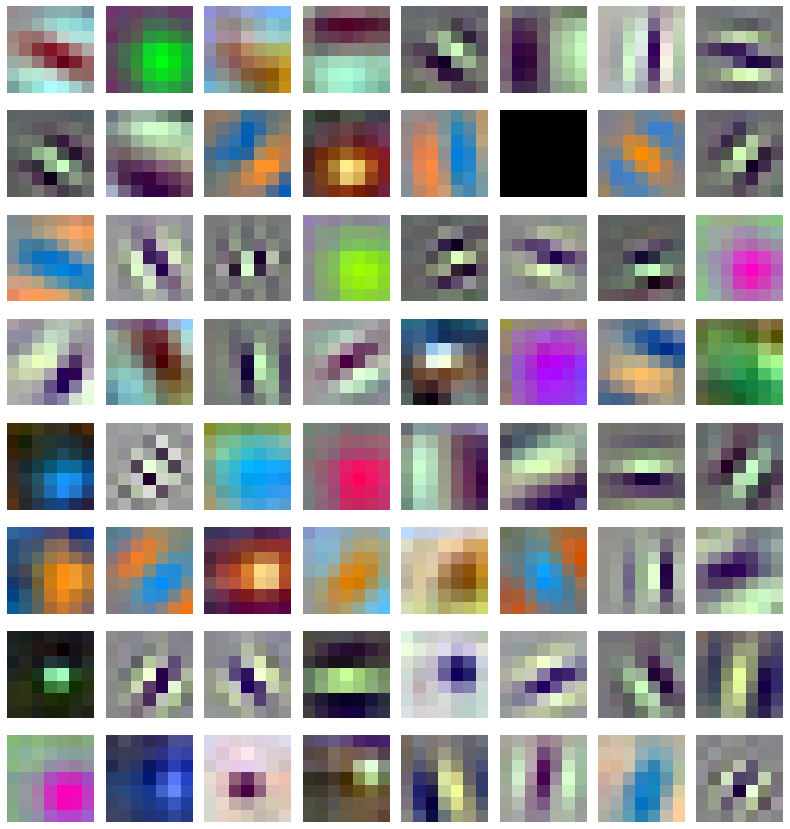

In [141]:
plot_filters(filters)